# PROJECT 3 COMPUTER VISION

In [ ]:
#!gdown 1uMwgC2hUU1FB9RpwfZbHVbEJnQk9-2D1

In [ ]:
#!unzip flowers.zip

- Joanna Szczublińska 156070
- Wiktoria Szarzyńska 156058

### `Step 1: Choose the dataset and convert images into Lab channels.`

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import pandas as pd
from tabulate import tabulate
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
import random
from sklearn.model_selection import KFold
from skimage.color import lab2rgb

In [ ]:
data_dir = "flowers"

In [ ]:
classes = os.listdir(data_dir)
print(classes)

['daisy', 'sunflower', 'rose', 'tulip', 'myOwnDataset', 'dandelion']


In [ ]:
X_l = []
Y_ab = []
labels = []

for label, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            img = cv2.imread(img_path)


            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                img = cv2.resize(img, (200, 200))

                lab  = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

                l_channel = lab[:, :, 0]
                ab_channels = lab[:, :, 1:]

                l_channel = l_channel / 255.0
                ab_channels = ab_channels / 128.0


                X_l.append(l_channel)
                Y_ab.append(ab_channels)
                labels.append(label)

In [ ]:
X_l = np.array(X_l, dtype=np.float32).reshape(-1, 200, 200, 1)  # we add one dimension because we want to X dimension be equal to Y dimension
Y_ab = np.array(Y_ab, dtype=np.float32)

labels = np.array(labels)

In [ ]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X_l, Y_ab, test_size=0.3, random_state=42) #70% for training and 30% for temporary dataset
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42) #50% for validation and 50% for testing

In [ ]:
print(f"#Training set: {len(X_train)}")
print(f"#Validation set: {len(X_val)}")
print(f"#Test set: {len(X_test)}")

In [ ]:
example_l = X_train[0].squeeze()
example_ab = Y_train[0]


example_lab = np.zeros((200, 200, 3))
example_lab[:, :, 0] = example_l * 100
example_lab[:, :, 1:] = example_ab * 128
example_rgb = lab2rgb(example_lab)


plt.figure(figsize=(15, 5))


plt.subplot(1, 4, 1)
plt.title("Reconstructed RGB Image")
plt.imshow(example_rgb)
plt.axis("off")


plt.subplot(1, 4, 2)
plt.title("L Channel")
plt.imshow(example_l, cmap="gray")
plt.axis("off")


plt.subplot(1, 4, 3)
plt.title("a Channel")
plt.imshow(example_ab[:, :, 0], cmap="seismic")


plt.subplot(1, 4, 4)
plt.title("b Channel")
plt.imshow(example_ab[:, :, 1], cmap="coolwarm")
plt.axis("off")

plt.show()


In [ ]:
example_l = X_train[1].squeeze()
example_ab = Y_train[1]


example_lab = np.zeros((200, 200, 3))
example_lab[:, :, 0] = example_l * 100
example_lab[:, :, 1:] = example_ab * 128
example_rgb = lab2rgb(example_lab)

plt.figure(figsize=(15, 5))


plt.subplot(1, 4, 1)
plt.title("Reconstructed RGB Image")
plt.imshow(example_rgb)
plt.axis("off")

plt.subplot(1, 4, 2)
plt.title("L Channel")
plt.imshow(example_l, cmap="gray")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("a Channel")
plt.imshow(example_ab[:, :, 0], cmap="seismic")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.title("b Channel")
plt.imshow(example_ab[:, :, 1], cmap="coolwarm")

plt.show()



In [ ]:
example_l = X_train[3].squeeze()
example_ab = Y_train[3]


example_lab = np.zeros((200, 200, 3))
example_lab[:, :, 0] = example_l * 100
example_lab[:, :, 1:] = example_ab * 128
example_rgb = lab2rgb(example_lab)

plt.figure(figsize=(15, 5))


plt.subplot(1, 4, 1)
plt.title("Reconstructed RGB Image")
plt.imshow(example_rgb)
plt.axis("off")

plt.subplot(1, 4, 2)
plt.title("L Channel")
plt.imshow(example_l, cmap="gray")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("a Channel")
plt.imshow(example_ab[:, :, 0], cmap="seismic")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.title("b Channel")
plt.imshow(example_ab[:, :, 1], cmap="coolwarm")
plt.axis("off")

plt.show()



### `Step 2: Model, ready architecture trained from scratch.`

In [ ]:
input_shape = (200, 200, 1)

# ENCODER
def build_encoder(input_layer):
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    return x

# DECODER
def build_decoder(encoded_layer):
    x = Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(encoded_layer)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    output_layer = Conv2D(2, (3, 3), activation='linear', padding='same')(x)  # Wyjście 2-kanałowe z aktywacją linear
    return output_layer

In [ ]:
input_layer = Input(shape=input_shape)
encoded = build_encoder(input_layer)
decoded = build_decoder(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200, 200, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 200, 200, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 50, 50, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 50, 50, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 100, 100, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 100, 100, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 200, 200, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 200, 200, 2)         │           1,154 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,329,730 (5.07 MB)

 Trainable params: 1,329,730 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

### `Step 3: Initial model training.`

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience=5, restore_best_weights=True)

In [ ]:
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [ ]:
def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

In [ ]:
autoencoder.compile(
    optimizer='adam',
    loss='mse',
    metrics=[psnr_metric, ssim_metric]
)

In [ ]:
batch_size = 32
epochs = 50

history = autoencoder.fit(
    X_train, Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, Y_val),
    callbacks = [early_stopping]
)

val_results = autoencoder.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_results[0]:.4f}, PSNR: {val_results[1]:.4f}, SSIM: {val_results[2]:.4f}")

In [ ]:
test_results = autoencoder.evaluate(X_test, Y_test)
print(f"Test Loss: {test_results[0]:.4f}, PSNR: {test_results[1]:.4f}, SSIM: {test_results[2]:.4f}")

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Trening Loss')
plt.plot(history.history['val_loss'], label='Walidation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss during tests')
plt.legend()
plt.show()

In [ ]:
n = 50
predicted_images = autoencoder.predict(X_test[:n])

for i in range(n):
    plt.figure(figsize=(15, 5))


    plt.subplot(1, 4, 1)
    plt.title("Original a and b Channels")
    plt.imshow(Y_test[i][:, :, 0], cmap='seismic')  # Wyświetlenie kanału a
    plt.axis('off')


    plt.subplot(1, 4, 2)
    plt.title("Grayscale (L Channel)")
    plt.imshow(X_test[i].reshape(200, 200), cmap='gray')
    plt.axis('off')


    plt.subplot(1, 4, 3)
    plt.title("Predicted a Channel")
    plt.imshow(predicted_images[i][:, :, 0], cmap='seismic')  # Kanał a
    plt.axis('off')


    plt.subplot(1, 4, 4)
    plt.title("Predicted b Channel")
    plt.imshow(predicted_images[i][:, :, 1], cmap='coolwarm')  # Kanał b
    plt.axis('off')

    plt.show()


### `Step 4: Let's make our model perfect.`

#### `Step 4.1: Testing three (3) different optimizers.`

In [ ]:
optimizers = {
    'Adam': Adam(learning_rate=0.001),
    'RMSprop': RMSprop(learning_rate=0.001),
    'SGD': SGD(learning_rate=0.01, momentum=0.9)  # With momentum for better convergence
}

results = {}

In [ ]:
for name, optimizer in optimizers.items():
    print(f"\nTraining with {name} optimizer:")

    autoencoder = Model(inputs = input_layer, outputs = decoded)
    autoencoder.compile(
        optimizer = optimizer,
        loss = 'mse',
        metrics = [psnr_metric, ssim_metric]
    )

    history = autoencoder.fit(
        X_train, Y_train,
        batch_size = 32,
        epochs = 20,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose = 1
    )

    val_loss, psnr, ssim = autoencoder.evaluate(X_val, Y_val, verbose=0)
    results[name] = {
        'Validation Loss': val_loss,
        'PSNR': psnr,
        'SSIM': ssim
    }

In [ ]:
print("\nComparison of Optimizers:")
for name, metrics in results.items():
    print(f"{name} - Validation Loss: {metrics['Validation Loss']:.4f}, PSNR: {metrics['PSNR']:.2f}, SSIM: {metrics['SSIM']:.4f}")

In [ ]:
table_data = [
    [optimizer, metrics["Validation Loss"], metrics["PSNR"], metrics["SSIM"]]
    for optimizer, metrics in results.items()
]

table = tabulate(
    table_data,
    headers=["Optimizer", "Validation Loss", "PSNR", "SSIM"],
    tablefmt="grid"
)

print("\nComparison of Optimizers:")
print(table)

#### `Step 4.2: Testing three (3) different loss functions.`

In [ ]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

In [ ]:
def train_model_with_loss(loss_function, loss_name):
    print(f"\nTraining model with {loss_name} loss...")
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=Adam(), loss=loss_function, metrics=[psnr_metric, ssim_metric])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = autoencoder.fit(
        X_train, Y_train,
        batch_size=32,
        epochs=10,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=0
    )

    val_results = autoencoder.evaluate(X_val, Y_val, verbose=0)
    return {"Validation Loss": val_results[0], "PSNR": val_results[1], "SSIM": val_results[2]}


In [ ]:
loss_results = {}

loss_functions = {
    "Mean Squared Error (MSE)": MeanSquaredError(),
    "Mean Absolute Error (MAE)": MeanAbsoluteError(),
    "Structural Similarity Index (SSIM) Loss": ssim_loss
}

for loss_name, loss_fn in loss_functions.items():
    loss_results[loss_name] = train_model_with_loss(loss_fn, loss_name)


In [ ]:
table_data = [
    [optimizer, metrics["Validation Loss"], metrics["PSNR"], metrics["SSIM"]]
    for optimizer, metrics in loss_results.items()
]

# Create the table with tabulate
table = tabulate(
    table_data,
    headers=["Optimizer", "Validation Loss", "PSNR", "SSIM"],
    tablefmt="grid"
)

# Print the result
print("\nComparison of Optimizers:")
print(table)

#### `Step 4.3: Hyperparameter tuning or estimation.`

Training with lr=1e-05, batch_size=48, epochs=100...
Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 47s 374ms/step - loss: 0.9046 - psnr_metric: 0.1875 - ssim_metric: 0.0954 - val_loss: 0.5964 - val_psnr_metric: 6.7425 - val_ssim_metric: 0.4036
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - loss: 0.5826 - psnr_metric: 7.5165 - ssim_metric: 0.4174 - val_loss: 0.5536 - val_psnr_metric: 8.5010 - val_ssim_metric: 0.4464
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - loss: 0.5453 - psnr_metric: 8.7392 - ssim_metric: 0.4547 - val_loss: 0.5141 - val_psnr_metric: 9.7010 - val_ssim_metric: 0.4859
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - loss: 0.5046 - psnr_metric: 9.9942 - ssim_metric: 0.4954 - val_loss: 0.4627 - val_psnr_metric: 11.5814 - val_ssim_metric: 0.5373
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - loss: 0.4657 - psnr_metric: 12.0441 - ssim_metric: 0.5343 - val_loss: 0.4418 - val_psnr_metric: 13.4399 - val_ssim_metric: 0.5582
Epoch 6/100
71/71 ━━━━━━

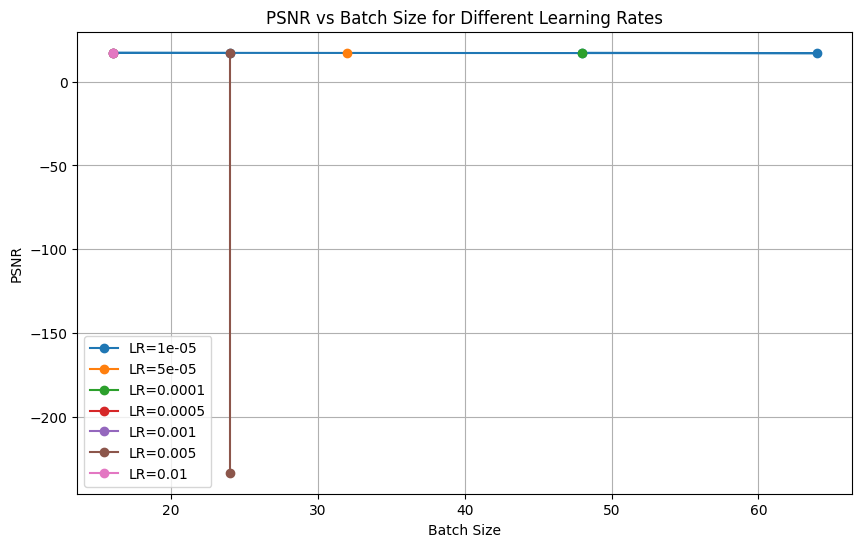

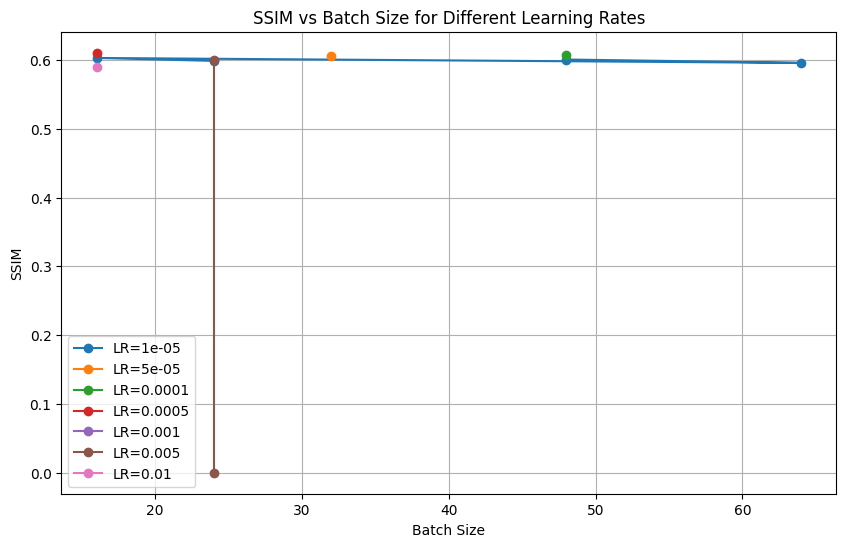

In [33]:
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
batch_sizes = [16, 24, 32, 48, 64]
epochs = (40, 100)

def train_model_with_params(learning_rate, batch_size, epochs):

    input_layer = Input(shape=input_shape)
    encoded = build_encoder(input_layer)
    decoded = build_decoder(encoded)

    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss=ssim_loss, metrics=[psnr_metric, ssim_metric])

    early_stopping = EarlyStopping(monitor='val_ssim_metric', patience=5, mode='max', restore_best_weights=True)


    history = autoencoder.fit(
        X_train, Y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )


    val_loss, psnr, ssim = autoencoder.evaluate(X_val, Y_val, verbose=0)

    return psnr, ssim

results = []


for _ in range(10):
    lr = random.choice(learning_rates)
    bs = random.choice(batch_sizes)
    ep = random.choice(epochs)

    print(f"Training with lr={lr}, batch_size={bs}, epochs={ep}...")
    psnr, ssim = train_model_with_params(lr, bs, ep)
    results.append((lr, bs, ep, psnr, ssim))


df = pd.DataFrame(results, columns=['Learning Rate', 'Batch Size', 'Epochs', 'PSNR', 'SSIM'])


plt.figure(figsize=(10, 6))
for lr in learning_rates:
    subset = df[df['Learning Rate'] == lr]
    plt.plot(subset['Batch Size'], subset['PSNR'], label=f'LR={lr}', marker='o')

plt.title('PSNR vs Batch Size for Different Learning Rates')
plt.xlabel('Batch Size')
plt.ylabel('PSNR')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
for lr in learning_rates:
    subset = df[df['Learning Rate'] == lr]
    plt.plot(subset['Batch Size'], subset['SSIM'], label=f'LR={lr}', marker='o')

plt.title('SSIM vs Batch Size for Different Learning Rates')
plt.xlabel('Batch Size')
plt.ylabel('SSIM')
plt.legend()
plt.grid(True)
plt.show()


#### `Step 4.4: Cross-validation.`

In [ ]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cv_results = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index]

    input_layer = Input(shape=input_shape)
    encoded = build_encoder(input_layer)
    decoded = build_decoder(encoded)

    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=Adam(), loss='mse', metrics=[psnr_metric, ssim_metric])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = autoencoder.fit(
        X_train_fold, Y_train_fold,
        batch_size=32,
        epochs=50,
        validation_data=(X_val_fold, Y_val_fold),
        callbacks=[early_stopping],
        verbose=0
    )

    val_loss, psnr, ssim = autoencoder.evaluate(X_val_fold, Y_val_fold, verbose=0)
    cv_results.append((val_loss, psnr, ssim))

cv_results = np.array(cv_results)
avg_val_loss = np.mean(cv_results[:, 0])
avg_psnr = np.mean(cv_results[:, 1])
avg_ssim = np.mean(cv_results[:, 2])

print(f"Average Validation Loss: {avg_val_loss:.4f}")
print(f"Average PSNR: {avg_psnr:.4f}")
print(f"Average SSIM: {avg_ssim:.4f}")


Average Validation Loss: 0.0282
Average PSNR: 16.6697
Average SSIM: 0.5731


### `Step 5: Final training.`

In [ ]:
learning_rate = 0.001
batch_size = 32
epochs = 80
input_shape = (200, 200, 1)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
cv_results = []
X = np.array(X_l)
Y = np.array(Y_ab)

In [ ]:
for train_index, val_index in kf.split(X):


    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]


    input_layer = Input(shape=input_shape)
    encoded = build_encoder(input_layer)
    decoded = build_decoder(encoded)

    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=ssim_loss,
        metrics=[psnr_metric, ssim_metric]
    )


    early_stopping = EarlyStopping(
        monitor="val_ssim_metric", patience=10, restore_best_weights=True, mode="max"
    )

    # Final Training
    history = autoencoder.fit(
        X_train, Y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )


    val_loss, val_psnr, val_ssim = autoencoder.evaluate(X_val, Y_val, verbose=0)
    print(f"Fold {fold_no} - Loss: {val_loss:.4f}, PSNR: {val_psnr:.4f}, SSIM: {val_ssim:.4f}")
    cv_results.append((val_loss, val_psnr, val_ssim))

    fold_no += 1


cv_results = np.array(cv_results)
print("\n--- Cross-Validation Results ---")
print(f"Average Loss: {cv_results[:, 0].mean():.4f}")
print(f"Average PSNR: {cv_results[:, 1].mean():.4f}")
print(f"Average SSIM: {cv_results[:, 2].mean():.4f}")

Epoch 1/80
121/121 ━━━━━━━━━━━━━━━━━━━━ 33s 234ms/step - loss: 0.5205 - psnr_metric: 10.3651 - ssim_metric: 0.4795 - val_loss: 0.4086 - val_psnr_metric: 16.5086 - val_ssim_metric: 0.5914
Epoch 2/80
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.4162 - psnr_metric: 16.1358 - ssim_metric: 0.5838 - val_loss: 0.4032 - val_psnr_metric: 16.9153 - val_ssim_metric: 0.5968
Epoch 3/80
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.4112 - psnr_metric: 16.3802 - ssim_metric: 0.5888 - val_loss: 0.4013 - val_psnr_metric: 16.5851 - val_ssim_metric: 0.5987
Epoch 4/80
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.4059 - psnr_metric: 16.6303 - ssim_metric: 0.5941 - val_loss: 0.3996 - val_psnr_metric: 16.9370 - val_ssim_metric: 0.6004
Epoch 5/80
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.4045 - psnr_metric: 16.8751 - ssim_metric: 0.5955 - val_loss: 0.3996 - val_psnr_metric: 16.4288 - val_ssim_metric: 0.6004
Epoch 6/80
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.

In [ ]:
autoencoder.save("./model.keras")

In [ ]:
n = 20
predicted_images = autoencoder.predict(X_test[:n])

for i in range(n):

    grayscale_img = X_test[i].reshape(200, 200)
    predicted_ab = predicted_images[i] * 128

    example_lab = np.zeros((200, 200, 3), dtype=np.float32)
    example_lab[:, :, 0] = grayscale_img
    example_lab[:, :, 1:] = predicted_ab


    img_reconstructed = cv2.cvtColor(example_lab.astype(np.float32), cv2.COLOR_Lab2RGB)


    plt.figure(figsize=(20, 5))


    plt.subplot(1, 5, 1)
    plt.title("Original a Channel")
    plt.imshow(Y_test[i][:, :, 0], cmap='seismic')
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.title("Original b Channel")
    plt.imshow(Y_test[i][:, :, 1], cmap='coolwarm')
    plt.axis('off')


    plt.subplot(1, 5, 3)
    plt.title("Grayscale (L Channel)")
    plt.imshow(grayscale_img, cmap='gray')
    plt.axis('off')


    plt.subplot(1, 5, 4)
    plt.title("Predicted a Channel")
    plt.imshow(predicted_ab[:, :, 0], cmap='seismic')
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.title("Predicted b Channel")
    plt.imshow(predicted_ab[:, :, 1], cmap='coolwarm')
    plt.axis('off')


    plt.figure(figsize=(6, 6))
    plt.title("Reconstructed RGB Image")
    plt.imshow(img_reconstructed)
    plt.axis('off')

    plt.show()


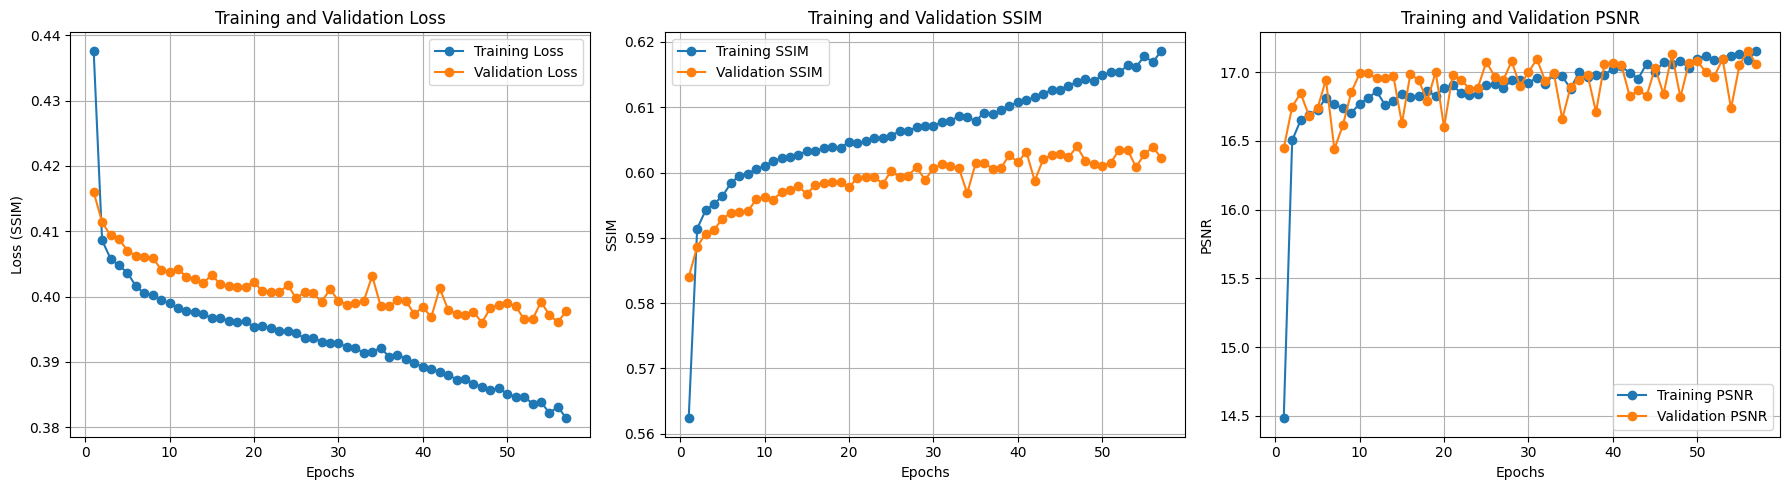

In [ ]:
history_dict = history.history


train_loss = history_dict['loss']
val_loss = history_dict['val_loss']


train_ssim = history_dict['ssim_metric']
val_ssim = history_dict['val_ssim_metric']

train_psnr = history_dict['psnr_metric']
val_psnr = history_dict['val_psnr_metric']

epochs_range = range(1, len(train_loss) + 1)


plt.figure(figsize=(18, 5))


plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (SSIM)")
plt.legend()
plt.grid()

# SSIM
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_ssim, label='Training SSIM', marker='o')
plt.plot(epochs_range, val_ssim, label='Validation SSIM', marker='o')
plt.title("Training and Validation SSIM")
plt.xlabel("Epochs")
plt.ylabel("SSIM")
plt.legend()
plt.grid()

# PSNR
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_psnr, label='Training PSNR', marker='o')
plt.plot(epochs_range, val_psnr, label='Validation PSNR', marker='o')
plt.title("Training and Validation PSNR")
plt.xlabel("Epochs")
plt.ylabel("PSNR")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
